# The purpose of this script is to run a two disclination simulation wherein the main numerical programs have been compiled by numba. This is supposed to speed up 

### Add path to source files

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.path.abspath('..'), 'src'))

### If not already created, make save folder for figures

In [11]:
save_folder = r'two-disclination-compiled-simulation-figures'
if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

### Import necessary libraries, import loading bars, make plots big

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import FiniteDifferenceCompiled as fd
import LiquidCrystalHelperCompiled as lch

from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt

import time
import timeit
from importlib import reload

import ipywidgets as widgets
from IPython.display import display
from IPython.display import Video
from IPython.display import Image

In [3]:
reload(fd)
reload(lch)

<module 'LiquidCrystalHelperCompiled' from 'C:\\Users\\lucas\\Documents\\Grad Work\\Summer Research 2020\\LiquidCrystalHydrodynamics\\src\\LiquidCrystalHelperCompiled.py'>

In [4]:
%matplotlib inline
dpi = 700
mpl.rcParams['figure.dpi'] = dpi

### Define domain, create initial auxiliary variable states for configuation

In [5]:
l = 10
n = 600

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

S_val = 0.5
ctr = [[-2, 0], [2, 0]]
r = [1, 1]
m = [-1/2, 1/2]

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

### Run forward euler scheme with step size `dt` and `num_steps` steps

In [6]:
dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/6

num_steps = 15000
peak_pos = np.zeros((2, num_steps))
t = np.zeros(num_steps)
widths = np.arange(0, 1.5, 0.05)

middle = np.floor(n/2).astype('int')
middle_slice = np.zeros((n, num_steps))

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

etaEuler = fd.makeForwardEuler(lch.etaEOM)
muEuler = fd.makeForwardEuler(lch.muEOM)
nuEuler = fd.makeForwardEuler(lch.nuEOM)

start_time = time.perf_counter()
for i in range(num_steps):
    
    eta_new = etaEuler(eta_old, dt, mu_old, nu_old, dx, dy)
    mu_new = muEuler(mu_old, dt, eta_old, nu_old, dx, dy)
    nu_new = nuEuler(nu_old, dt, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peaks, _ = find_peaks(-lambda_max[:, middle])
    middle_slice[:, i] = lambda_max[:, middle]
    if peaks.shape[0] <= 2:
        peak_pos[:, i] = X[peaks, middle]
    else:
        break
        
    t[i] = i*dt
    
    # Update loading bar
    progress.value = i
    
# truncate arrays if loop stops early
t = t[:i]
peak_pos = peak_pos[:, :i]
    
end_time = time.perf_counter()
print("Simulation ran in", (end_time - start_time)/60, "minutes.")

IntProgress(value=0, max=15000)

Simulation ran in 5.453541031666666 minutes.


### Plot peak position vs. time

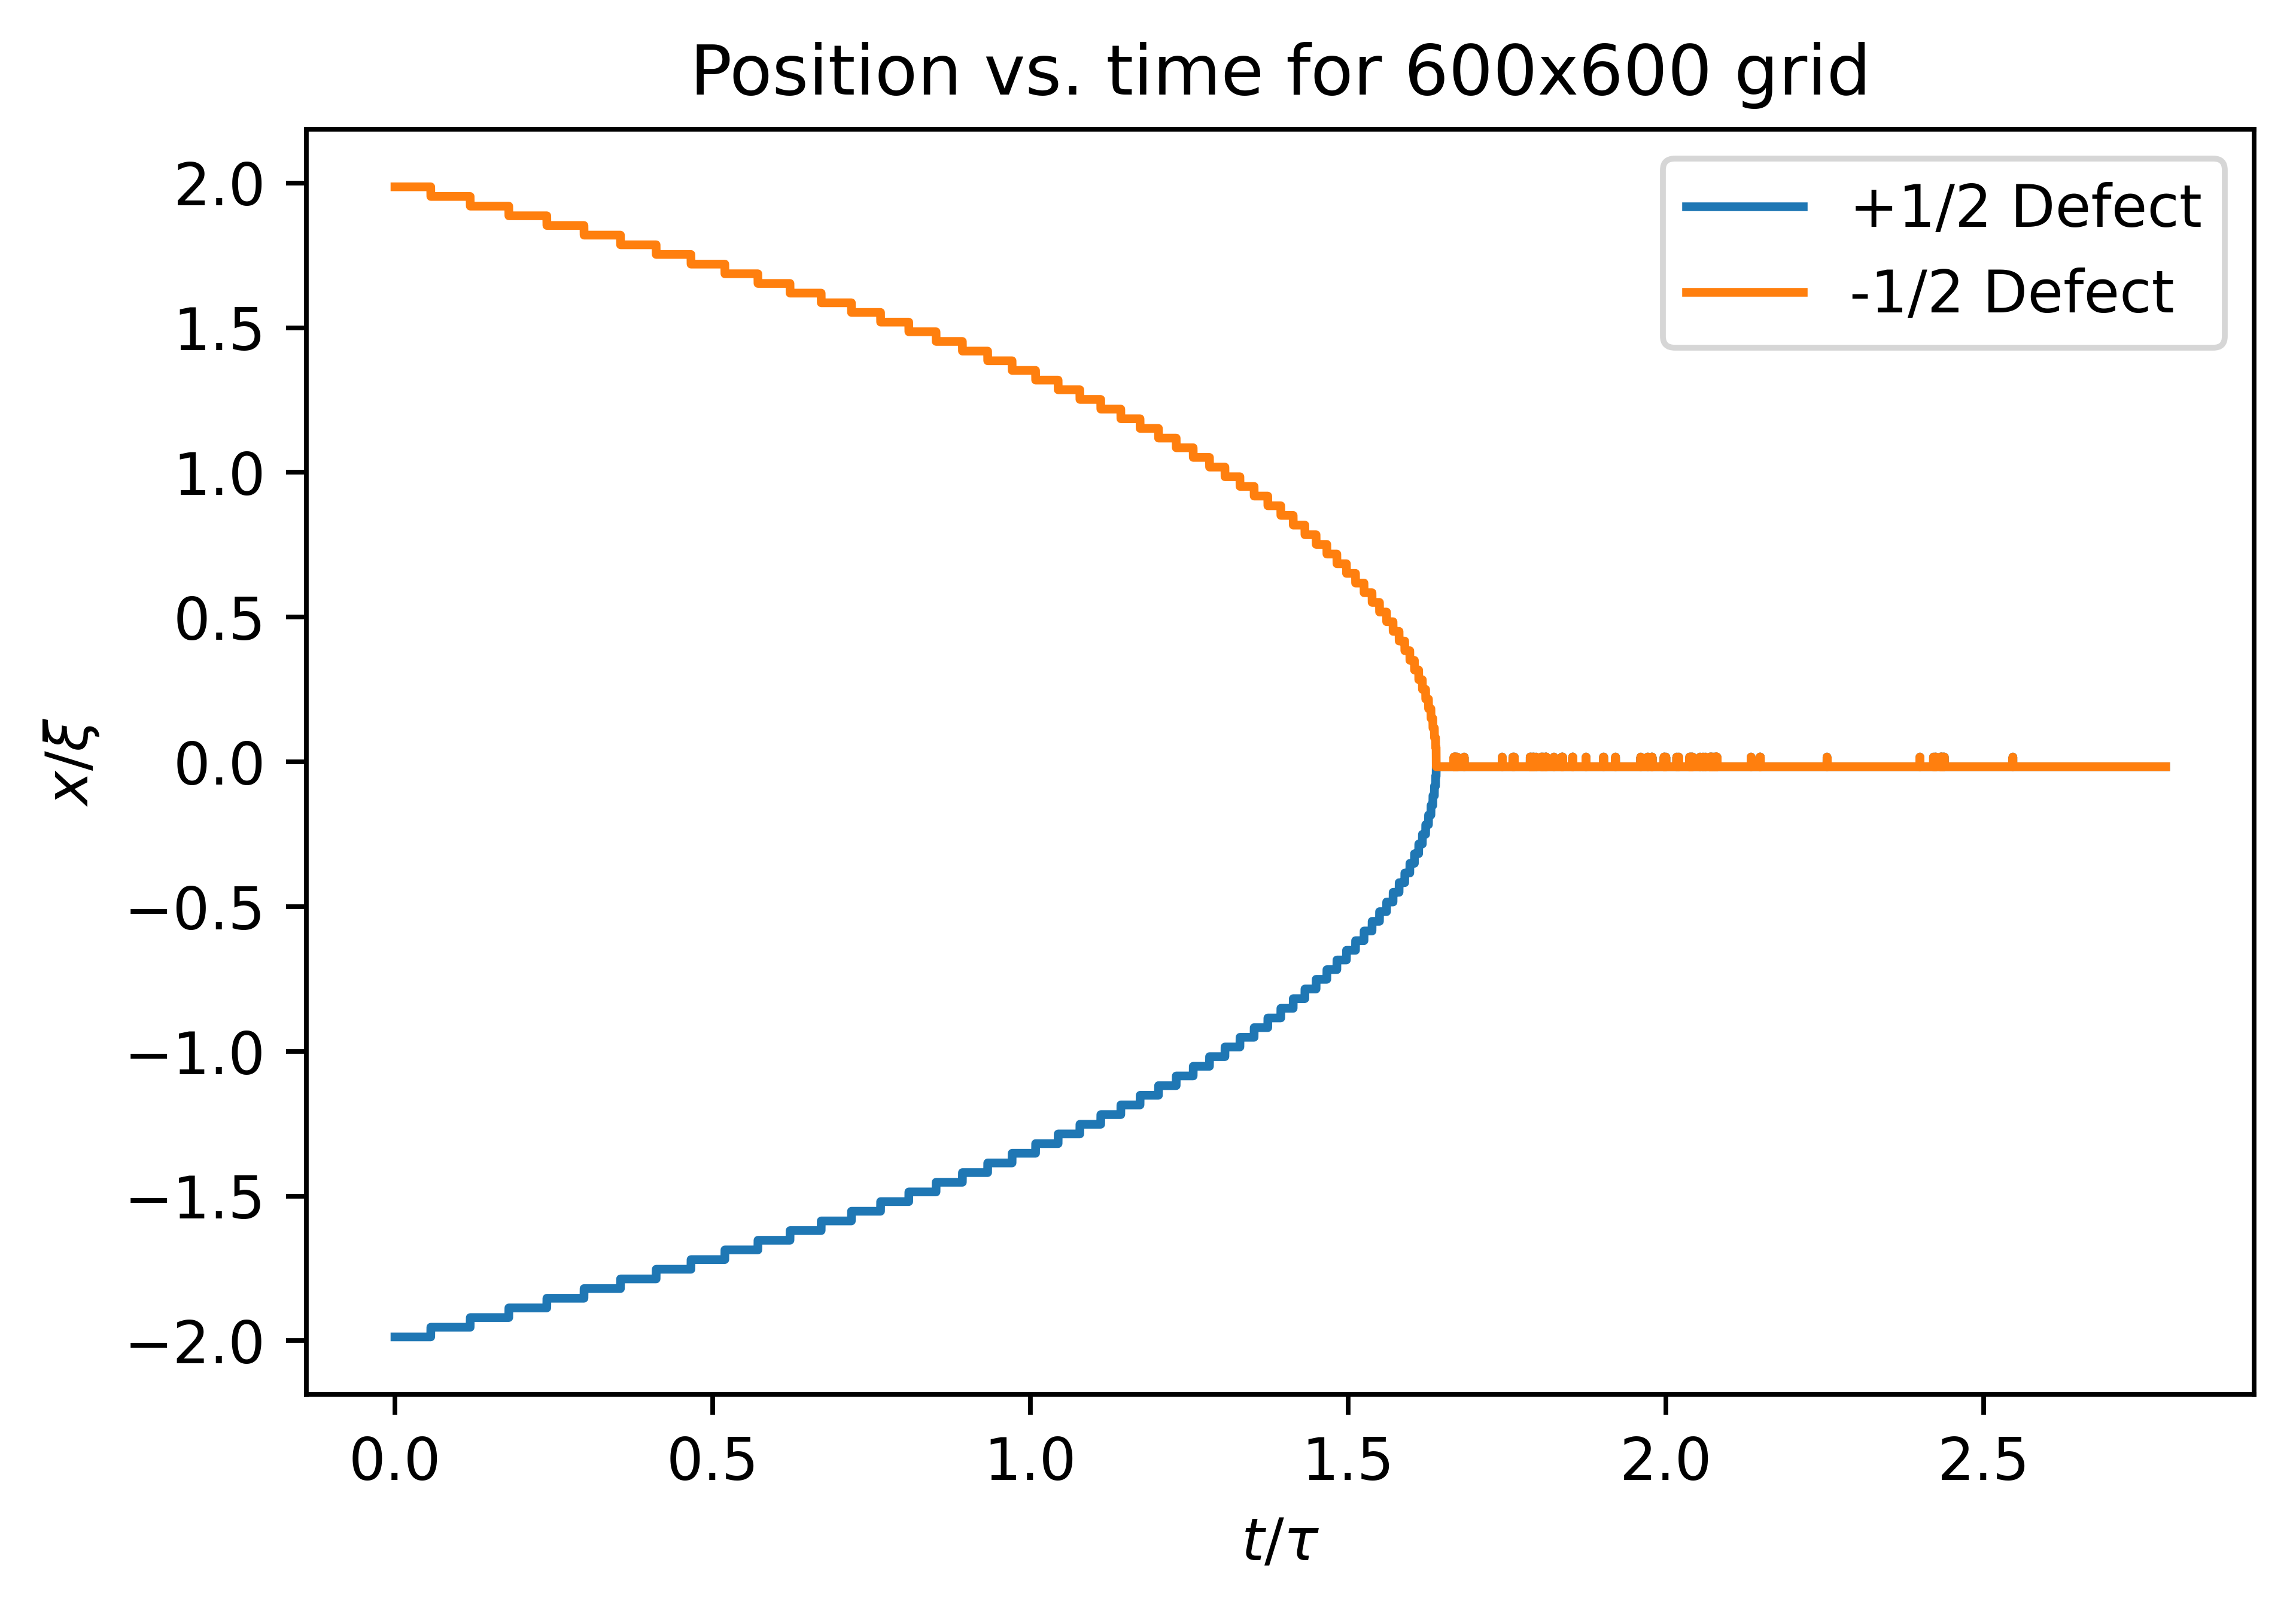

In [13]:
plt.plot(t[:], peak_pos[0, :], label='+1/2 Defect')
plt.plot(t[:], peak_pos[1, :], label='-1/2 Defect')

plt.title('Position vs. time for 600x600 grid')
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$x/\xi$')
plt.legend()

filename_defect_pos_vs_time = os.path.join(save_folder, r'defect-pos-vs-time-600pts.png')
plt.savefig(filename_defect_pos_vs_time)

### Plot difference between consecutive gridpoints to check how big the jumps are

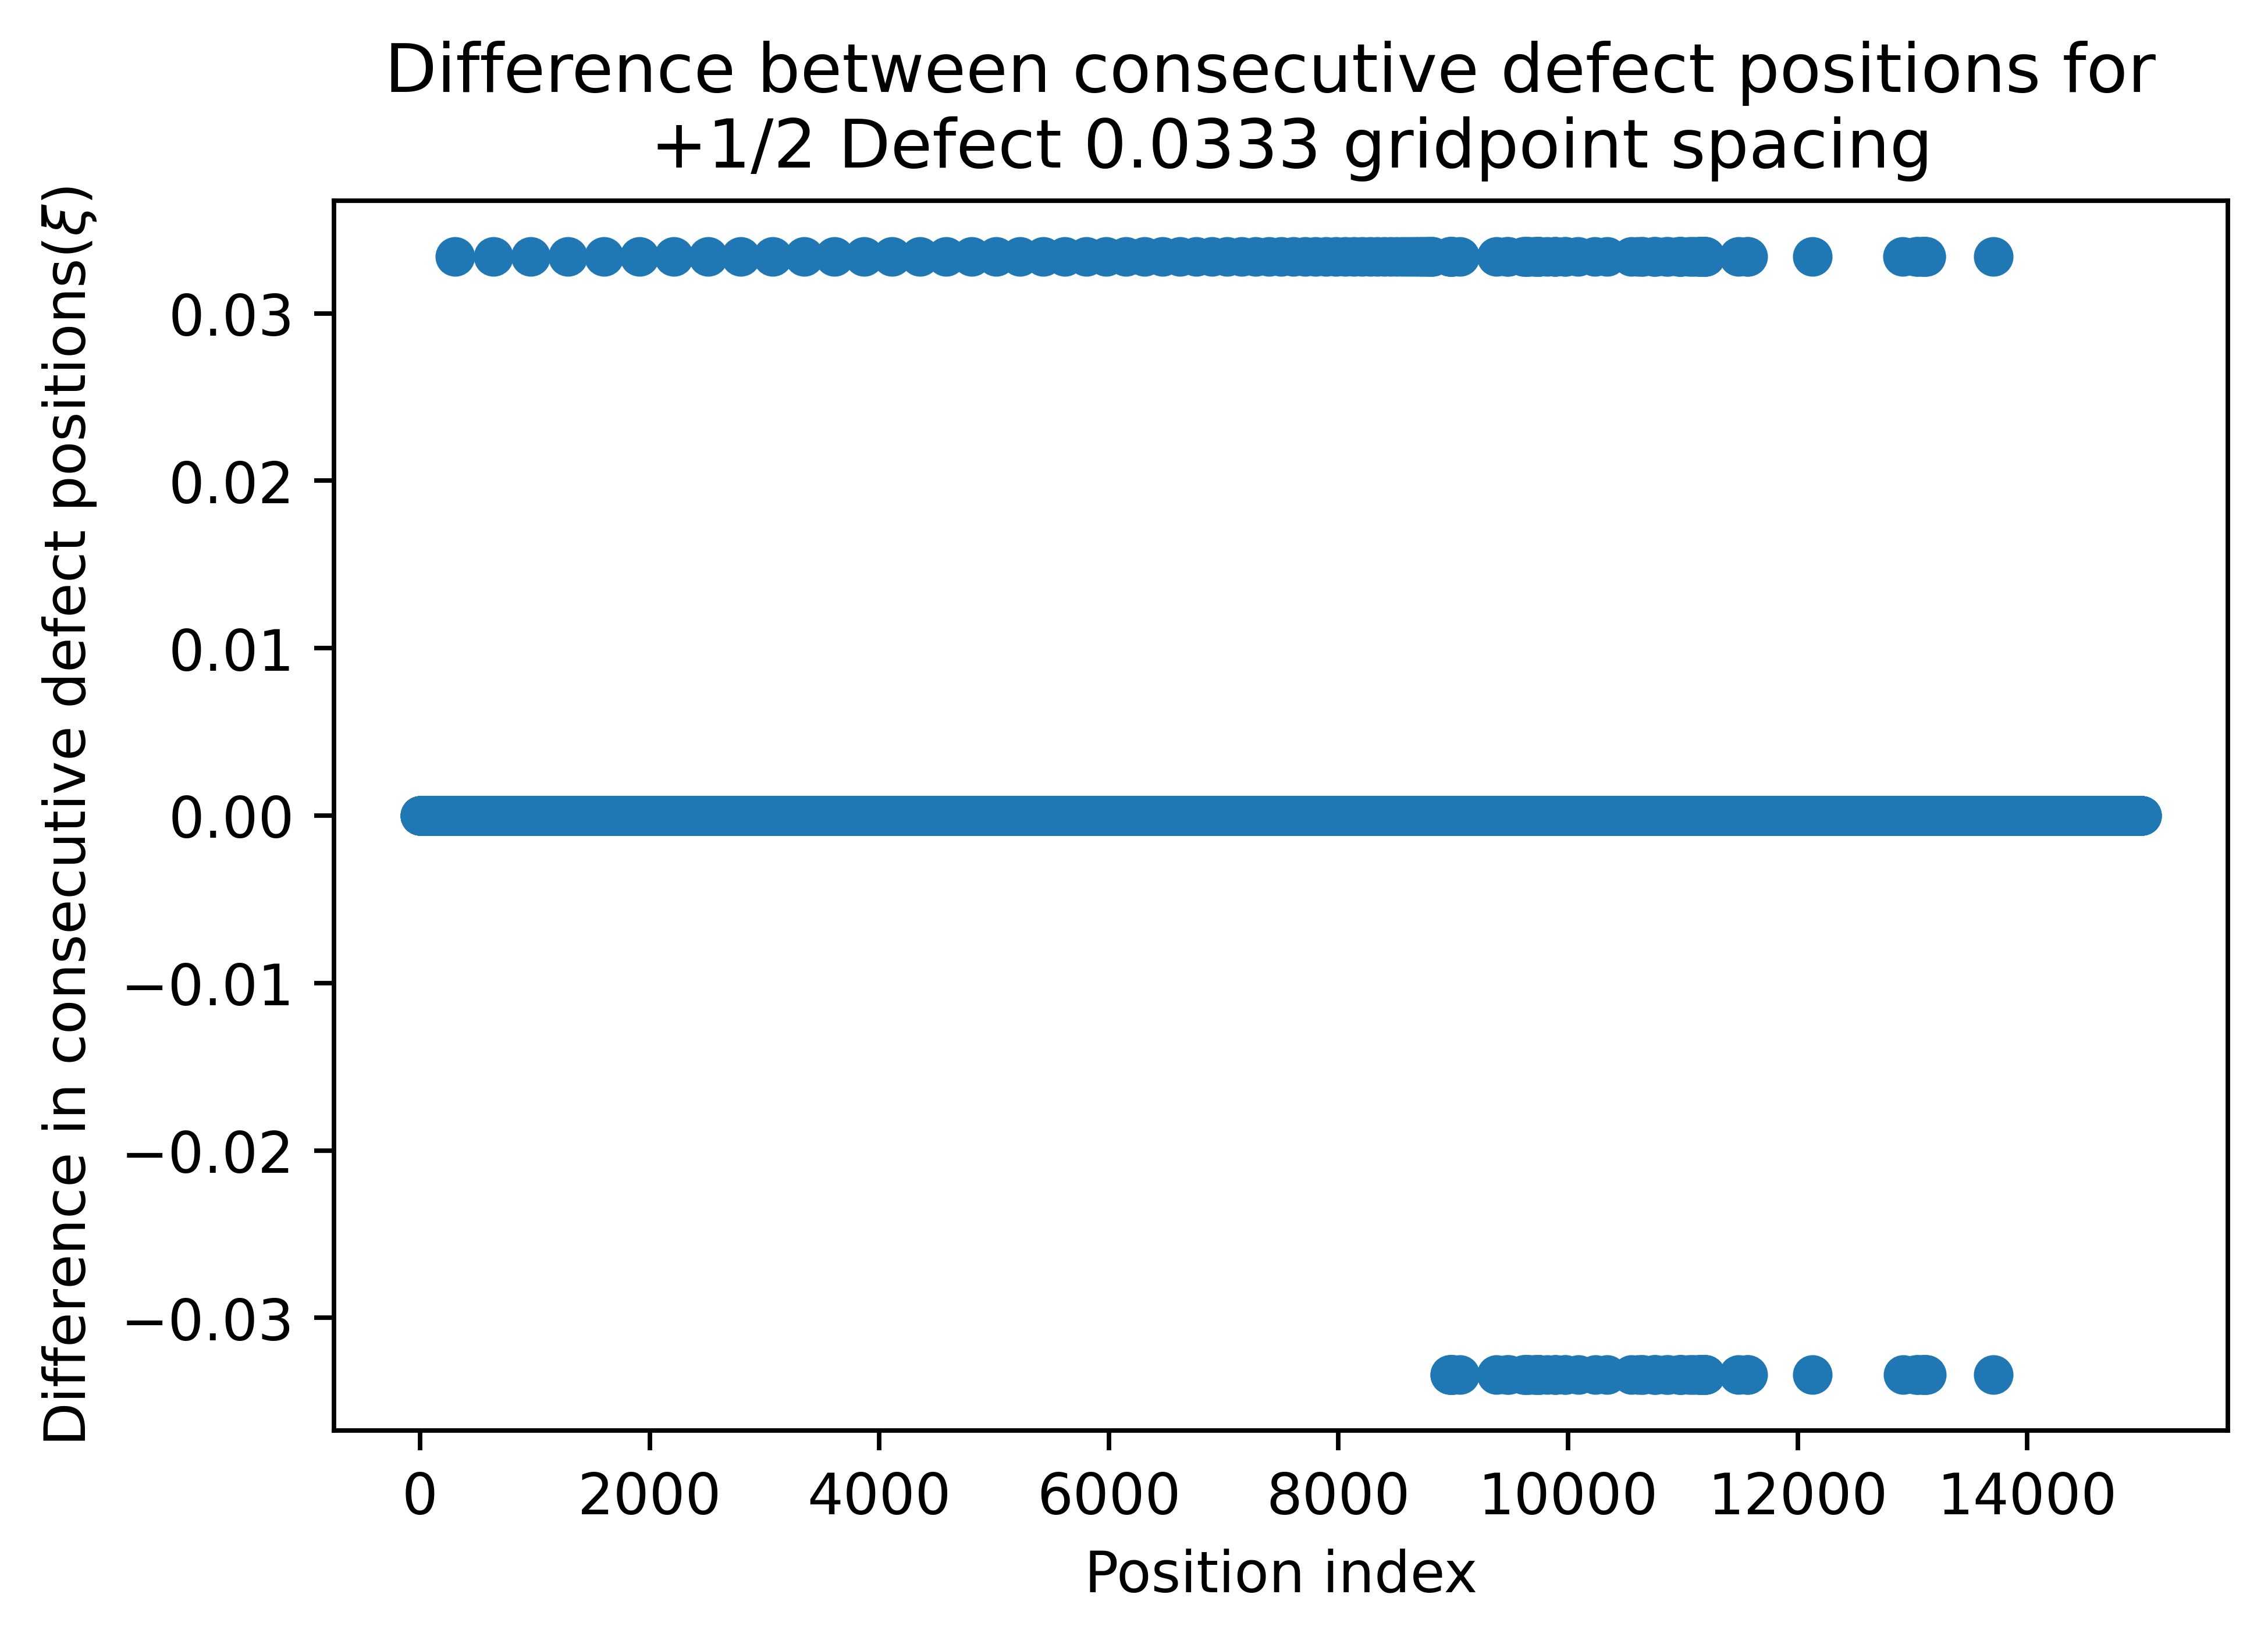

In [21]:
plt.plot(np.diff(peak_pos[0, :]), marker='o', ls='')

plt.title('Difference between consecutive defect positions for \n +1/2 Defect ' + str(round(2*l/n, 4)) + ' gridpoint spacing')
plt.ylabel(r'Difference in consecutive defect positions($\xi$)')
plt.xlabel('Position index')

filename_defect_pos_diffs = os.path.join(save_folder, r'defect-pos-diffs-600pts.png')
plt.savefig(filename_defect_pos_diffs)